In [1]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(f'Możliwe urządzenie: {device}')

Możliwe urządzenie: cuda


In [2]:
# generowanie danych, dwa koła z punktów jedno w drugim X[(x,y)pozycja], y[0 lub 1], dane wymieszane
from sklearn.datasets import make_circles 
X, y = make_circles(1000, noise=0.03, random_state=42)
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

https://scikit-learn.org/stable/modules/classes.html#samples-generator

In [3]:
circles = pd.DataFrame({'X1': X[:, 0], 'X2': X[:, 1], 'label': y})
circles[:5]

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


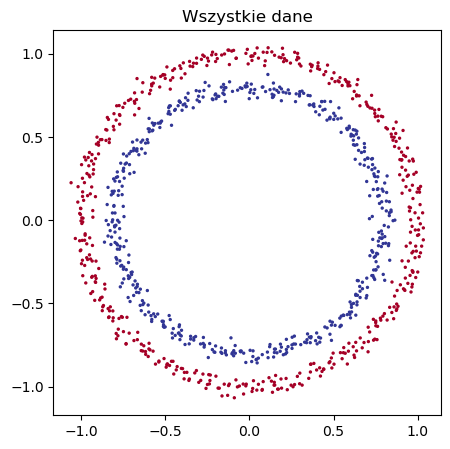

In [4]:
plt.figure(figsize=(5, 5))
plt.title('Wszystkie dane')
plt.scatter(X[:,0], X[:,1], s=2, c=y, cmap=plt.cm.RdYlBu);

### Zadaniem będzie nauczenie maszyny granicy obszarów wewnętrznego (1) i zewnętrnego (0)

In [5]:
# zamiana na tensory i ustalwienie na cuda, oraz rozłożenie na trening i test
X = torch.tensor(X).type(torch.float32).to(device)
y = torch.tensor(y).type(torch.float32).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# wizualizacja danych treningowych i testowych
# colory https://matplotlib.org/stable/users/explain/colors/colormaps.html

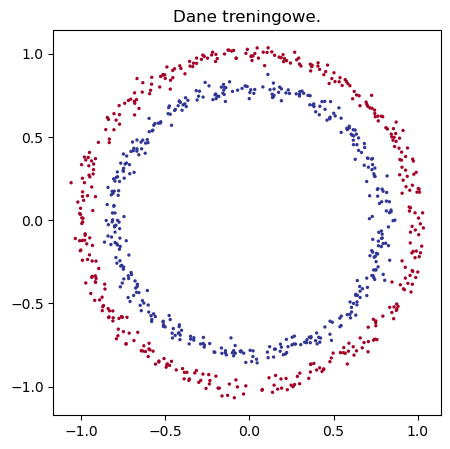

In [7]:
plt.figure(figsize=(5, 5))
plt.title('Dane treningowe.')
plt.scatter(X_train[:,0].cpu().numpy(), X_train[:,1].cpu().numpy(), s=2, c=y_train.cpu().numpy(), cmap=plt.cm.RdYlBu);

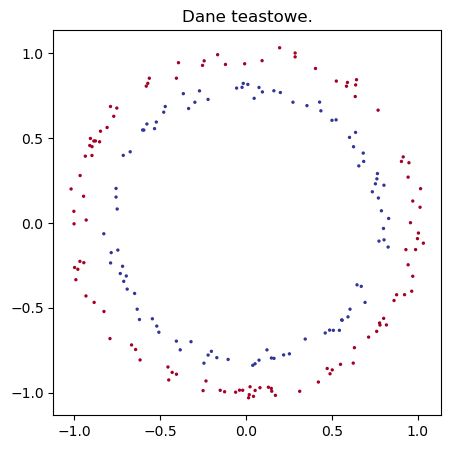

In [8]:
plt.figure(figsize=(5, 5))
plt.title('Dane teastowe.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=y_test.cpu().numpy(), cmap=plt.cm.RdYlBu);

In [9]:
# budowanie modelu

In [10]:
# Model oparty o klasę
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer_1 = nn.Linear(in_features=2,  # dane wejściowe
                                 out_features=5) # dane wyjściowe do warstwy ukrytej
        self.layer_2 = nn.Linear(in_features=5,  # dane wejściowe do warstwy ukrytej
                                 out_features=1) # dane wyjściowe
    def forward(self, x):
        return self.layer_2(self.layer_1(x))  # in x -> layer_1 -> layer_2 -> output

# torch.manual_seed(2)
# model = ModelNN().to(device)

# poprawiony 
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer_1 = nn.Linear(in_features=2, out_features=16) 
        self.layer_2 = nn.Linear(in_features=16, out_features=16) 
        self.layer_3 = nn.Linear(in_features=16, out_features=1) 
        self.relu = nn.ReLU() # dodanie funkcji aktywacyjnej nie liniowej, łamie linie na mniejsze
    
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = ModelNN().to(device)

In [11]:
# Model sekwencyjny
# torch.manual_seed(42)
# model = nn.Sequential(
#     nn.Linear(in_features=2, out_features=16),
#     # nn.ReLU(),
#     nn.Linear(in_features=16, out_features=32),
#     nn.ReLU(),
#     nn.Linear(in_features=32, out_features=1)
# ).to(device)
# dzięki ReLU funkcja liniowa podzieliła linie na kilka mniejszych, ale trzeba dodać jeszcze warstwe ukrytą

In [12]:
# model.state_dict() # parametry modelu

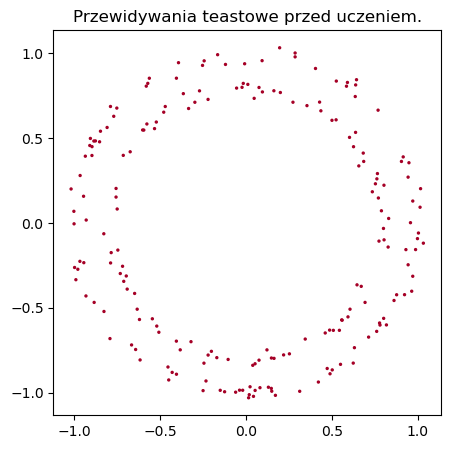

In [13]:
# przewidywania przed uczeniem
with torch.inference_mode(): 
    y_preds = model(X_test)
# y_preds, y_preds.shape
plt.figure(figsize=(5, 5))
plt.title('Przewidywania teastowe przed uczeniem.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=np.round(y_preds.cpu().numpy()), cmap=plt.cm.RdYlBu);

### Ustawienia loss i optymalizator
* https://pytorch.org/docs/stable/nn.html#loss-functions
* https://pytorch.org/docs/stable/optim.html
* https://www.learnpytorch.io/02_pytorch_classification/#21-setup-loss-function-and-optimizer

In [14]:
# torch.nn.BCEWithLogitsLoss to funkcja straty w bibliotece PyTorch, 
# która łączy w sobie funkcję straty logistycznej regresji binarnej (BCELoss) oraz funkcję aktywacji logitów (Sigmoid). 
# W skrócie, ta funkcja straty jest często stosowana w zadaniach klasyfikacji binarnej.
loss_fn = nn.BCEWithLogitsLoss() # cross entropy + sigmoid activation function

# sigmoid jest dla binary classification
# softmax jest dla multiclass calssification

# torch.optim.SGD to klasa optymalizatora w bibliotece PyTorch, 
# która implementuje algorytm stochastycznego spadku gradientu (SGD). 
# Jest to jeden z najbardziej podstawowych algorytmów optymalizacji używanych w uczeniu maszynowym.
# optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.1) 

In [15]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

### Prawidłowe przetworzenie danych wyjściowych dla binary classification

In [16]:
# rzeczywiste dane wyjściowe 
y_test[:5]

tensor([1., 1., 0., 1., 1.], device='cuda:0')

In [17]:
# dane wejściowe przepuszczone przez model (forward), jeszcze bez uczenia
model.eval() # używane podczas testowania lub ewaluacji modelu, gdy nie ma potrzeby aktualizowania wag
with torch.inference_mode():
    y_logits = model(X_test[:5])
y_logits    

tensor([[-0.1318],
        [-0.0999],
        [-0.1177],
        [-0.1175],
        [-0.1308]], device='cuda:0')

In [18]:
# rzeczywiste dane są w postaci int a wynikowe w postaci float, czeba ustawić wyjściowe na int

In [19]:
# użycie funkcji sigmoid dla binary classification
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4671],
        [0.4750],
        [0.4706],
        [0.4707],
        [0.4674]], device='cuda:0')

In [20]:
# dalej są float, trzeba je teraz zaokrąglić

In [21]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [22]:
# format ten sam, ale dane jezszcze nie wytrenowane

In [23]:
# teraz wszystko w jednej linii
y_pred_labels = torch.round(torch.sigmoid(model(X_test[:5])))
y_pred_labels.squeeze()

tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

## Trening i test

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000
epoch_count = []
loss_values = []
acc_values = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss wymaga jako wejście raw preds (y_logits)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    epoch_count.append(epoch)
    loss_values.append(loss)
    acc_values.append(acc)    
    
model.eval()
with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

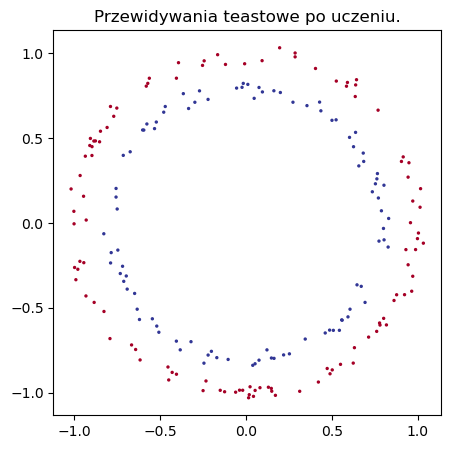

In [25]:
plt.figure(figsize=(5, 5))
plt.title('Przewidywania teastowe po uczeniu.')
plt.scatter(X_test[:,0].cpu().numpy(), X_test[:,1].cpu().numpy(), s=2, c=np.round(test_pred.cpu().numpy()), cmap=plt.cm.RdYlBu);

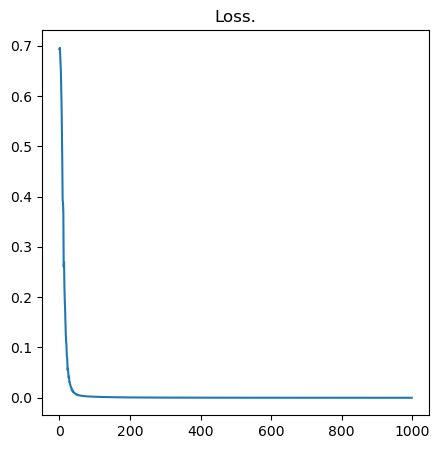

In [26]:
plt.figure(figsize=(5, 5))
plt.title('Loss.')
plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()), label='Train loss')

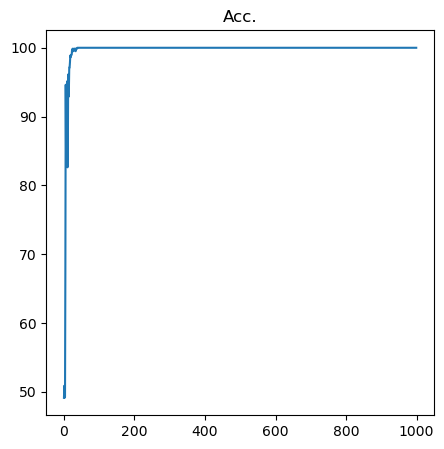

In [27]:
plt.figure(figsize=(5, 5))
plt.title('Acc.')
plt.plot(epoch_count, np.array(torch.tensor(acc_values).cpu().numpy()), label='Train acc')

In [28]:
import requests
from pathlib import Path
# Pobranie repo z gita lub innego adresu jeżeli nie jest jeszcze pobrane
if Path('helper_functions.py').is_file():
    print('helper_functions.py już jest')
else:
    print('pobieram helper_functions.py')
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

helper_functions.py już jest


In [29]:
from helper_functions import plot_predictions, plot_decision_boundary

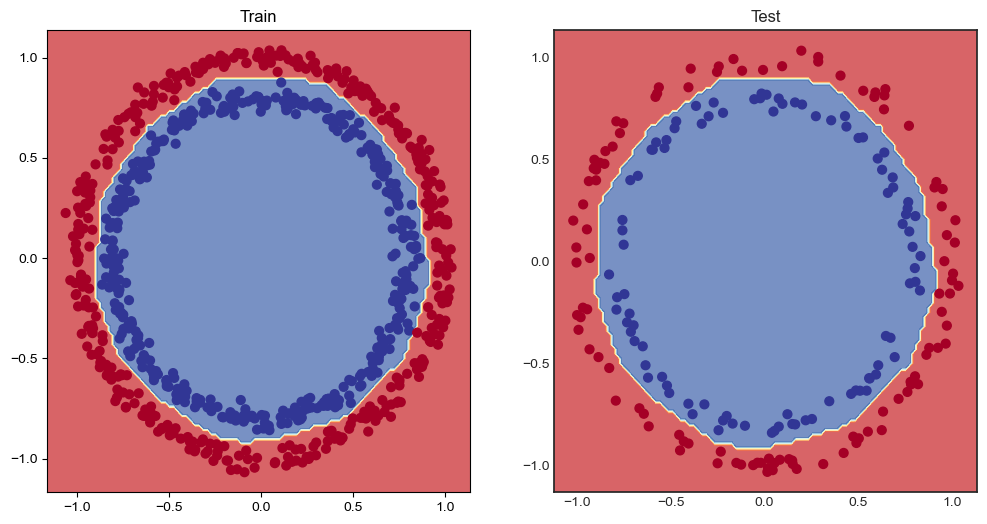

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)